In [1]:
# !pip install --upgrade scikit-learn
# ! pip install pydotplus


### 1. Imports des modules

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image  
import pydotplus

from statistics import mean 

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz


#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


/home/agaltier/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### 2. Lecture des données

In [3]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

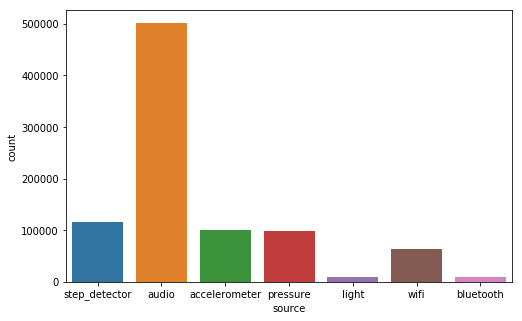

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="source", data=smartphone_df[smartphone_df.source.isin(['step_detector',
 'audio',
 'accelerometer',
 'pressure',
 'light',
 'wifi',
 'bluetooth'])])

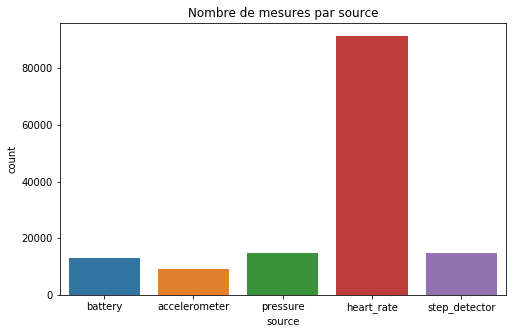

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="source", data=smartwatch_df[smartwatch_df.source.isin(['battery',
'accelerometer',
'pressure',
'heart_rate',
'step_detector'])]).set_title('Nombre de mesures par source')

### 3. Preparation des donnees Smartwatch

In [ ]:
data = {}

data['heart_rate'] = [None] * len(smartwatch_df)

for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]


smartwatch_df["heart_rate"] = data['heart_rate']

resampling_functions = {
    'heart_rate': np.mean,
}

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['heart_rate'].notnull()  
    
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df['heart_rate']
smartwatch_df = smartwatch_df.resample('min').agg(resampling_functions)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

            timestamp          
heart_rate  2017-06-29 07:46:00    129.568182
            2017-06-29 07:47:00    111.095238
            2017-06-29 07:48:00     75.076923
            2017-06-29 07:49:00     68.076923
            2017-06-29 07:50:00     64.666667
Name: heart_rate, dtype: float64

In [ ]:
data = {}

data['audio'] = [None] * len(smartphone_df)
data['steps'] = [None] * len(smartphone_df)
data['wifi'] = [None] * len(smartphone_df)
data['accelerometer'] = [None] * len(smartphone_df)


for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    
    if row['source'] != 'activity':
        values = [ float(x) for x in ast.literal_eval(row['values']) ]

        if row['source'] == 'audio':
            data['audio'][index] = mean(values)

        if row['source'] == 'step_detector':
            data['steps'][index] = values[0]

        if row['source'] == 'accelerometer':
            data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

        if row['source'] == 'wifi':
            data['wifi'][index] = len(values)

smartphone_df["audio"] = data['audio']
smartphone_df["wifi"] = data['wifi']
smartphone_df["steps"] = data['steps']
smartphone_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'audio': np.mean,
    'wifi': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartphone_df = smartphone_df[ 
                    smartphone_df['audio'].notnull() | 
                    smartphone_df['wifi'].notnull() | 
                    smartphone_df['steps'].notnull() |
                    smartphone_df['accelerometer'].notnull()
                             ]

smartphone_df = smartphone_df.set_index('timestamp')
smartphone_df = smartphone_df[['audio','wifi', 'steps', 'accelerometer']]
smartphone_df = smartphone_df.resample('min').agg(resampling_functions)
smartphone_df['steps'].fillna(0.0, inplace=True)
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=1528218), HTML(value='')))

### 3. Jointure des datasets

In [ ]:
df = smartphone_df.join(smartwatch_df, lsuffix='_sp', rsuffix='_sw')
df = df.reset_index(level=0)
df = df.drop('level_0', axis = 1)
df.head()

In [ ]:
df.describe()

In [ ]:
report_df.head()

In [ ]:
data = {}
data['activity_index'] = [None] * len(df)
data['activity_type'] = [None] * len(df)

i=0
for index, row in tqdm(df.iterrows(), total=len(df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

df["activity_type"] = data['activity_type']
df = df.dropna()

# df['hour'] = pd.Series(list(df.index)).dt.hour.tolist()

df['hour'] = df.index.hour
add_var = pd.get_dummies(df['hour'], prefix='hour', drop_first=True)
df = df.join(add_var)
df = df.drop(columns=['hour'])

df.head()

### 3. Exploration des donnees

In [ ]:
df.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

In [ ]:
df = df.drop(df.index[df['activity_type'] == 'At home'], axis = 0)
df = df.drop(df.index[df['activity_type'] == 'Walking&party'], axis = 0)
for activity_type in df['activity_type'].unique():
    if len(df[df['activity_type'] == activity_type])<30:
        df = df.drop(df.index[df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

In [ ]:
list(df.columns)

In [ ]:
variables = [
    'audio',
    'wifi',
    'steps',
    'accelerometer',
    'heart_rate',
#     'hour',
]

hours = [
    'hour_10',
    'hour_11',
    'hour_12',
    'hour_13',
    'hour_14',
    'hour_15',
    'hour_16',
    'hour_17',
    'hour_18',
    'hour_19',
    'hour_21'
]


# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(df[variables])
normal = normal_scaler_fit.transform(df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(normal, columns=variables)


y = df['activity_type']

df_normal = pd.DataFrame(normal, columns=variables)
df_normal['activity_type'] = df['activity_type'].tolist()

X = X.join(pd.DataFrame(np.array(df[hours]), columns = hours))

In [ ]:
df_normal.head()

In [ ]:
df[variables].describe()

In [ ]:
df_normal.describe()

In [ ]:
for variable in [
                    'audio',
                    'wifi',
                    'steps',
                    'accelerometer',
                    'heart_rate'
                ]:
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(style="ticks", color_codes=True)
    sns.boxplot(x="activity_type", y=variable, data=df, showfliers=False)

### 4.  Corrélations

In [ ]:
# Matrice de correlation
corr = X[[
            'audio',
            'wifi',
            'steps',
            'accelerometer',
            'heart_rate'
                ]].corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

In [ ]:
n_components = 5
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X[[
                    'audio',
                    'wifi',
                    'steps',
                    'accelerometer',
                    'heart_rate'
                ]])

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

### 5. Classification

#### Sans l'ACP:

In [ ]:
# activites = ['Eat']
# labels = []
# for activity_type in list(y['activity_type']):
#     if activity_type in activites:
#         labels.append(1)
#     else:
#         labels.append(0)

# labels = y['activity_type']
labels = y

In [ ]:
# len(labels.unique())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=101)

In [ ]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
    "Random Forest"
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))

    accuracy = cross_val_score(clf, X, labels, scoring='accuracy', cv = 15)
    print(accuracy)
    #get the mean of each fold 
    print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
    
    

#### Avec l'ACP:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=21)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    
    accuracy = cross_val_score(clf, X, labels, scoring='accuracy', cv = 15)
    print(accuracy)
    #get the mean of each fold 
    print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
    

In [ ]:
dtree = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())